# Imports, 'Google Drive' mounting and GPU checking


In [1]:
import pandas
import keras
import matplotlib
import tensorflow
import numpy
import threading
import time
import itertools
import datetime

from dateutil.parser import parse

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, LSTM

from google.colab import drive

In [2]:
drive.mount('/content/drive')

device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

Mounted at /content/drive
Found GPU at: /device:GPU:0


# Project's code

## Project's functions...

In [13]:
# ================================================================================================================================================================================ #
def raw_data_import(source_file_names):
  """
  Utility function used to import raw data from 'Google Drive'
  """
  output = pandas.DataFrame() 

  start = time.time()
  
  for source_filename, column_name in source_file_names.items():
    raw_data_from_csv = pandas.read_csv(source_filename, names=['Date Time', column_name], header=0, parse_dates=['Date Time'])
    output = output.join(raw_data_from_csv.set_index('Date Time'), how='outer')
  
  print('Time used for raw data import: {}'.format(time.time() - start))

  return output


# ================================================================================================================================================================================ #
def manage_missing_time_series_records(input):
  """
  Utility function used to look for missing records, filling them using linear interpolation apporach.
  """
  
  first_date = input.iloc[0].name
  last_date = input.iloc[len(input) - 1].name

  # Create a new index to check for missing records into provided dataset...
  new_index = pandas.date_range(start=first_date, end=last_date, freq="1s")

  expected_number_of_records = len(new_index)
  provided_number_of_records = len(input)

  if provided_number_of_records != expected_number_of_records:
    print('Missing records detected!\n\tExpected number of records: {}\n\tProvided number of records: {}'.format(expected_number_of_records, provided_number_of_records))

    # Set new index, filling missing values with NaN...
    start = time.time()
    output = input.reindex(new_index)
    print('\nTime used for \'reindex\' method execution: {}'.format(time.time() - start))

    # Filling all 'NaN' in a Series via linear interpolation.
    start = time.time()   
    output = output.interpolate(method='linear', limit_direction='forward')
    print('\nTime used for \'interpolate\' method execution: {}'.format(time.time() - start))
  
    return output

  else:
    
    print('No missing records detected!')   
    return input


# ================================================================================================================================================================================ #
def plot_data(data, title, data_column_names, x_label="", y_label=""):
  """
  Utility function used to plot data.
  """
  
  matplotlib.pyplot.rcParams['figure.figsize'] = [20, 10]
  matplotlib.pyplot.rcParams['figure.dpi'] = 70
    
  plot_data = data[data_column_names]
  plot_data.index = data.index
  plot_data.head()
  plot_data.plot(rot=25, title=title)

  matplotlib.pyplot.xlabel(x_label)
  matplotlib.pyplot.ylabel(y_label)
  matplotlib.pyplot.show()


# ================================================================================================================================================================================ #
def import_data(source_file_names):
  """
  Utility function used to import data, manage missing data and extract new features.
  """

  output = raw_data_import(source_file_names)
  output = manage_missing_time_series_records(output)
  output = features_extraction(output)

  return output

# ================================================================================================================================================================================ #
def plot_prediction_results(appliance_name, predicted_data, real_data):
  """
  Utility function used to plot prediction results compared to real data.
  """

  matplotlib.pyplot.rcParams['figure.figsize'] = [20, 10]
  matplotlib.pyplot.rcParams['figure.dpi'] = 70

  figure, axes = matplotlib.pyplot.subplots()
    
  axes.plot(real_data, label='real_data')
  axes.plot(predicted_data, label='predicted_data')
  axes.legend(loc='upper center', shadow=True)

  matplotlib.pyplot.show()


# ================================================================================================================================================================================ #
def plot_loss(history):
  """
  Utility function used to plot 'loss' function trend. It is used to show that, after one point, the loss stops decreasing.
  """
    
  epochs = range(len(history.history["loss"]))

  matplotlib.pyplot.figure()
    
  matplotlib.pyplot.plot(epochs, history.history["loss"], label="Training loss")
  matplotlib.pyplot.plot(epochs, history.history["val_loss"], label="Validation loss")

  matplotlib.pyplot.title("Model Loss")
  matplotlib.pyplot.ylabel("Loss")
  matplotlib.pyplot.xlabel("Epoch")

  matplotlib.pyplot.legend(loc="upper left")
  matplotlib.pyplot.show()


# ================================================================================================================================================================================ #
def from_seconds_to_days(input):
  return input / (60 * 60 * 24)


# ================================================================================================================================================================================ #
def compute_f1_score(predicted_values, real_values):
  """
  Utility function used to compute the 'Energy Based F1 score' according to project specifications.
  """

  if len(predicted_values) != len(real_values):
    raise ValueError("ERROR: 'predicted_values' and 'real_values' have different size!")

  if len(predicted_values) == 0:
    raise ValueError("ERROR: 'predicted_values' and 'real_values' are empty!")

  if not isinstance(predicted_values, list) or not isinstance(real_values, list):
    raise ValueError("ERROR: Only 'list' type are accepted!")

  numerator = 0.0

  for x in range(0, len(predicted_values)):
    numerator += min(predicted_values[x], real_values[x])
  
  numerator_p = numerator
  denominator_p = sum(predicted_values)

  numerator_r = numerator
  denominator_r = sum(real_values)

  p = numerator_p / denominator_p
  r = numerator_r / denominator_r

  return 2 * ((p * r) / (p + r))


# ================================================================================================================================================================================ #
def evaluate_on_test_set(appliance_name, test_X, test_Y):

  score = compute_f1_score(test_X, test_Y)
  print("==> 'Energy Based F1 Score is: {}'".format(score))
    
  plot_prediction_results(appliance_name, test_X, test_Y)


# ================================================================================================================================================================================ #
def features_extraction(input):
  """
  Utility function used to extract new features in order to improve our model's performance.
  """

  seconds = 60 * 4     # Euristically chosen...

  # Add new features...
  input["Min"] = numpy.nan
  input["Max"] = numpy.nan
  input["Mean"] = numpy.nan

  for x in range(0, len(input),seconds):
  
    interval = input[x:x+seconds]

    input.iloc[x:x+seconds]["Min"] = interval['Aggregate power consumption'].min()
    input.iloc[x:x+seconds]["Max"] = interval['Aggregate power consumption'].max()
    input.iloc[x:x+seconds]["Mean"] = interval['Aggregate power consumption'].mean()

  return input


# ================================================================================================================================================================================ #
def start_hyperparameters_selection_phase(neural_network, reduced_training_X, reduced_training_Y, validation_X, validation_Y):
  """
  This function is used to start hyperparameters selection phase.
  """

  best_val_loss_score = 1.0
  best_hyperparameters = None
  best_number_of_epochs = 1
  
  for hyperparameters in neural_network.get_hyperparameters_list():

    neural_network.build(hyperparameters, debug=True)
    neural_network.train_for_hyperparameter_selection(reduced_training_X, reduced_training_Y, validation_X, validation_Y)

    history = neural_network.get_history()

    epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
    current_val_loss_value = history.history['val_loss'][epoch_index]

    if current_val_loss_value < best_val_loss_score:
      
      best_val_loss_score = current_val_loss_value
      best_hyperparameters = hyperparameters
      best_number_of_epochs = epoch_index + 1
      
  return best_hyperparameters, best_number_of_epochs

# ================================================================================================================================================================================ #
def start(validation_technique, neural_network, appliance_name, perform_training, perform_test_set_evaluation):
  """
  This function is used to perform both training or the evaluation on test set.
  """

  # Indentify all required sets...
  reduced_training_X, reduced_training_Y = validation_technique.get_reduced_training_set()
  training_X, training_Y = validation_technique.get_training_set()
  validation_X, validation_Y = validation_technique.get_validation_set()
  
  if perform_training:
    
    # Hyperparameter selection...
    hyperparameters, number_of_epochs = start_hyperparameters_selection_phase(neural_network, reduced_training_X, reduced_training_Y, validation_X, validation_Y)

    print("Best hyperparameters are:                {}".format(hyperparameters))
    print("Number of epochs for final training are: {}".format(number_of_epochs))

    # Final build and train...
    neural_network.build(hyperparameters, debug=True)
    neural_network.train(number_of_epochs, training_X, training_Y)

  if perform_test_set_evaluation:
    
    test_X, test_Y = validation_technique.get_test_set()

    # Make predictions...
    test_X = neural_network.predict(test_X)

    # Check performance on test set...
    predicted = validation_technique.unpreprocess_label_data(test_X)
    real = validation_technique.unpreprocess_label_data(test_Y)

    evaluate_on_test_set(appliance_name, predicted, real)

## Project's classes...

In [12]:
# ================================================================================================================================================================================ #
class RawDataPreprocessor(object):
  """
  This class is used to easly preprocess using 'standardisation'
  """

  def __init__(self, data, train_1, train_2):

    self._data = data
    if len(data.shape) == 1:
      
      self._num_features = 1

      self._data_mean = data[train_1:train_2].mean()
      self._data_std = data[train_1:train_2].std()

    else:

      self._num_features = data.shape[1]
      self._dictionary = {}

      for x in range(0, self._num_features):
       
        data_mean = data[train_1:train_2,x].mean()
        data_std = data[train_1:train_2,x].std() 
       
        self._dictionary["{}_mean".format(x)] = data_mean
        self._dictionary["{}_std".format(x)] = data_std
    
  def get_pre_processed_data(self):

    if self._num_features == 1:
      return (self._data - self._data_mean) / self._data_std

    for x in range(0, self._num_features):
      
      data_mean = self._dictionary["{}_mean".format(x)]
      data_std = self._dictionary["{}_std".format(x)]

      self._data[:,x] = (self._data[:,x] - data_mean) / data_std

    return self._data

  def get_un_processed_data(self, input):

    if self._num_features == 1:
      return (input * self._data_std) + self._data_mean

    for x in range(0, self._num_features):
      
      data_mean = self._dictionary["{}_mean".format(x)]
      data_std = self._dictionary["{}_std".format(x)]

      input[:,x] = (input[:,x] * self._data_std) + self._data_mean

    return input


# ================================================================================================================================================================================ #
class NeuralNetworkHyperparameters(object):
  """
  This class is intended to hold several hyperparameters combination, where:
  
  F - The number of filters.
  K - The size of each kernel.
  D - The number of neurons of Dense layer
  H - The number of neurons in the recurrent layer
  
  Each hyperparameters combination is in the form [F,K,D,H]
  """

  def __init__(self):
    self._hyperparameters = [
      [4, 2, 16, 16],     
      [8, 4, 32, 32],
      [16, 8, 64, 64],
      [16, 8, 1024, 64],
      [32, 16, 1024, 128]                
    ]

  def get_hyperparameters_list(self):
    return self._hyperparameters

# ================================================================================================================================================================================ #
class NilmNeuralNetwork(NeuralNetworkHyperparameters):
  """
  This class is used to represent the neural newtork of the 'dishwasher' appliance.
  """
  
  def __init__(self, name, batch_size, number_of_features):
    
    super().__init__()

    self._name = name
    self._batch_size = batch_size
    self._number_of_features = number_of_features
    self._history = None
    self._model = None
    
  def get_history(self):
    return self._history

  def build(self, hyperparameters, debug=True):
    
    # Current hyperparameters combination
    h = hyperparameters  

    if debug:
      print('The number of filters                        : {}'.format(h[0]))
      print('The size of each kernel                      : {}'.format(h[1]))
      print('The number of neurons of Dense layer         : {}'.format(h[2]))
      print('The number of neurons in the recurrent layer : {}'.format(h[3]))


    self._model = Sequential()
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same', input_shape=(self._number_of_features, 1)))
    self._model.add(LSTM(h[3]))
    self._model.add(Dense(h[2], activation='relu'))
    self._model.add(Dense(h[2]/2, activation='relu'))
    self._model.add(Dense(h[2]/4, activation='relu'))
    self._model.add(Dense(1, activation='linear'))

    self._model.compile(optimizer='adam', loss='mae')
    
    if debug:
      self._model.summary()


  def train_for_hyperparameter_selection(self, training_X, training_Y, validation_X, validation_Y): 

    # Following callback is required in order to save the best model observed during training 
    # To avoid overfitting, we will use 'EarlyStopping' approach... 
    earlystop_callback = EarlyStopping(monitor = 'val_loss',
                                       patience = 3,                                                  
                                       restore_best_weights = True,                                   
                                       verbose=1)

    # Reshape...
    training_X = training_X.reshape(training_X.shape[0], training_X.shape[1], 1)
    training_Y = training_Y.reshape(training_Y.shape[0], training_Y.shape[1], 1)

    validation_X = validation_X.reshape(validation_X.shape[0], validation_X.shape[1], 1)
    validation_Y = validation_Y.reshape(validation_Y.shape[0], validation_Y.shape[1], 1)

    # Train...
    self._history = self._model.fit(training_X, 
                                    training_Y, 
                                    epochs=10, 
                                    batch_size=self._batch_size, 
                                    callbacks=[earlystop_callback], 
                                    validation_data=(validation_X, validation_Y))
    
    plot_loss(self._history)

  def train(self, number_of_epochs, training_X, training_Y): 

    # Reshape...
    training_X = training_X.reshape(training_X.shape[0], training_X.shape[1], 1)
    training_Y = training_Y.reshape(training_Y.shape[0], training_Y.shape[1], 1)

    # Train...
    self._history = self._model.fit(training_X, 
                                    training_Y, 
                                    epochs=number_of_epochs, 
                                    batch_size=self._batch_size)
    
  def predict(self, input): 

    # Reshape...
    input = input.reshape(input.shape[0], input.shape[1], 1)

    # Predict...
    input = self._model.predict(input)

    # Reshape....
    input = input.reshape(input.shape[0], input.shape[1])
    
    return input[:,0]

  def save_to_disk(self):
    self._model.save('./{}.h5'.format(self._name))

  def load_from_disk(self):
    self._model = keras.models.load_model('./{}.h5'.format(self._name))

# ================================================================================================================================================================================ #
class SlidingWindowWalkForward(object):
  """
  Custom implementation of 'Sliding Windows' version of 'Walk Forward' validation technique.
    
  In this way, is possible to train our model excluding any future data from the training process, excluding data which is too far in the past too!
  """

  def __init__(self, raw_data, aggregate_column_name, appliance_column_name, number_of_iteration=2, debug=True):
        
    self._raw_data = raw_data
    self._number_of_iterations = number_of_iteration
    self._iteration_index = 0

    # Columns names...
    self._aggregate_column_name = aggregate_column_name
    self._appliance_column_name = appliance_column_name
    
    # First/Last observation's index belonging to 'Training Set'
    self._train_1 = None
    self._train_2 = None

    # First/Last observation's index belonging to 'Validation Set'
    self._val_1 = None
    self._val_2 = None

    # First/Last observation's index belonging to 'Test Set'
    self._test_1 = None
    self._test_2 = None

    # Following objects represent 'pandas.Series' objects containing PRE-PROCESSED data
    self._appliance_data_series_preprocessed = None
    self._aggregate_data_series_preprocessed = None

    # Following objects represent 'DataPreprocessor' objects used to PRE-PROCESS data
    self._appliance_data_preprocessor = None
    self._aggregate_data_preprocessor = None

    # Test/Validation set's number of observations is the same as stated by in project's specifications: 16 days of data!
    self._test_set_size = self._validation_set_size = len(pandas.date_range(start=parse("2019-03-15 00:00:00"), end=parse("2019-03-31 23:59:59"), freq="1s"))
      
    # Training set's number of observations is twice higher than that of test set.
    self._training_set_size = self._test_set_size * 2

    # Following instruction is used to compute the number of observations required by one iteration.
    self._data_size_used_during_iteration = self._training_set_size + self._validation_set_size + self._test_set_size

    # The 'Sliding Windows Step' represents the number of observations to ignore after each iteration.
    self._sliding_window_step = None

    # Following variable is used to represent the number of observations to ignore in current iteration.
    self._ignore_observations_up_to = 0
  
    self._compute_sliding_window_step_length()
    self.move_sliding_window(debug=debug)                    # Setup 'Sliding Window'
    self._build_preprocessed_data()
  
    if debug:
      print("Data size used during iteration: {} ({} days!)".format(self._data_size_used_during_iteration, from_seconds_to_days(self._data_size_used_during_iteration)))
      print("Sliding window step set size:    {} ({} days!)".format(self._sliding_window_step, from_seconds_to_days(self._sliding_window_step)))
      print("Number of iterations:            {}".format(self._number_of_iterations))

      print("Validation set size:             {} ({} days!)".format(self._validation_set_size, from_seconds_to_days(self._validation_set_size)))
      print("Training set size:               {} ({} days!)".format(self._training_set_size, from_seconds_to_days(self._training_set_size)))
      print("Test set size:                   {} ({} days!)".format(self._test_set_size, from_seconds_to_days(self._test_set_size)))

  def _compute_sliding_window_step_length(self):
      
    size = len(pandas.date_range(start=parse("2019-01-01 00:00:00"), end=parse("2019-03-31 23:59:59"), freq="1s"))
        
    self._sliding_window_step = int((size - self._data_size_used_during_iteration) / self._number_of_iterations)
    
  def _build_preprocessed_data(self):
    
    aggregate_data_series = self._raw_data[self._aggregate_column_name]
    aggregate_data_series.index = self._raw_data.index
    
    appliance_data_series = self._raw_data[self._appliance_column_name]
    appliance_data_series.index = self._raw_data.index

    # Build necessary 'RawDataPreprocessor' objects in order to pre-process data...
    self._aggregate_data_preprocessor = RawDataPreprocessor(aggregate_data_series.values, self._train_1, self._train_2)
    self._appliance_data_preprocessor = RawDataPreprocessor(appliance_data_series.values, self._train_1, self._train_2)

    self._aggregate_data_series_preprocessed = pandas.DataFrame(self._aggregate_data_preprocessor.get_pre_processed_data())
    self._appliance_data_series_preprocessed = pandas.DataFrame(self._appliance_data_preprocessor.get_pre_processed_data())

  def move_sliding_window(self, debug=True):
    """
    This method is used to setup/move the 'Siliding Window'.
    """

    self._train_1 = self._ignore_observations_up_to
    self._train_2 = self._train_1 + self._training_set_size

    self._val_1 = self._train_2
    self._val_2 = self._val_1 + self._validation_set_size

    self._test_1 = self._val_2
    self._test_2 = self._test_1 + self._test_set_size

    index = self._raw_data.index
    
    print('Current iteration:     {}'.format(self._iteration_index))
    print('Training set:          [{}:{}] -- [{} to {}]'.format(self._train_1, self._train_2, index[self._train_1], index[self._train_2 -1]))
    print('Validation set:        [{}:{}] -- [{} to {}]'.format(self._val_1, self._val_2, index[self._val_1], index[self._val_2 -1]))
    print('Ignored observations:  {}\n'.format(self._ignore_observations_up_to))

    if debug:
      print('Test set:              [{}:{}] -- [{} to {}]'.format(self._test_1, self._test_2, index[self._test_1], index[self._test_2 -1]))

    self._ignore_observations_up_to += self._sliding_window_step
    self._iteration_index += 1

  def get_test_set(self):
    """
    This method is used to get PRE-PROCESSED data belonging to VALIDATION set, including 'features' (test_X) and 'labels' (test_Y).
    """

    test_X = self._aggregate_data_series_preprocessed.values[self._test_1:self._test_2]
    test_Y = self._appliance_data_series_preprocessed.values[self._test_1:self._test_2]

    test_Y = test_Y.reshape(test_Y.shape[0],)

    return test_X, test_Y

  def get_validation_set(self):
    """
    This method is used to get PRE-PROCESSED data belonging to VALIDATION set, including 'features' (validation_X) and 'labels' (validation_Y).
    """

    validation_X = self._aggregate_data_series_preprocessed.values[self._val_1:self._val_2]
    validation_Y = self._appliance_data_series_preprocessed.values[self._val_1:self._val_2]

    return validation_X, validation_Y
       
  def get_reduced_training_set(self):
    """
    This method is used to get PRE-PROCESSED data belonging to REDUCED TRAINING set, including 'features' (training_X) and 'labels' (training_Y).

    Please observe that so-called 'reduced training set' is intended for hyperparameter selection, not for final training! (See the report for more details...)
    """

    training_X = self._aggregate_data_series_preprocessed.values[self._train_1:self._train_2]
    training_Y = self._appliance_data_series_preprocessed.values[self._train_1:self._train_2]
   
    return training_X, training_Y

  def get_training_set(self, reduced=True):
    """
    This method is used to get PRE-PROCESSED data belonging to TRAINING set, including 'features' (training_X) and 'labels' (training_Y).
    """

    training_X = self._aggregate_data_series_preprocessed.values[self._train_1:self._val_2]
    training_Y = self._appliance_data_series_preprocessed.values[self._train_1:self._val_2]

    return training_X, training_Y

  def unpreprocess_label_data(self, input):
    return self._appliance_data_preprocessor.get_un_processed_data(input).tolist()

  def unpreprocess_feature_data(self, input):
    return self._aggregate_data_preprocessor.get_un_processed_data(input).tolist()

# Script for training...

Time used for raw data import: 194.03078961372375
Missing records detected!
	Expected number of records: 6307200
	Provided number of records: 6082508

Time used for 'reindex' method execution: 0.5317189693450928

Time used for 'interpolate' method execution: 1.0962588787078857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

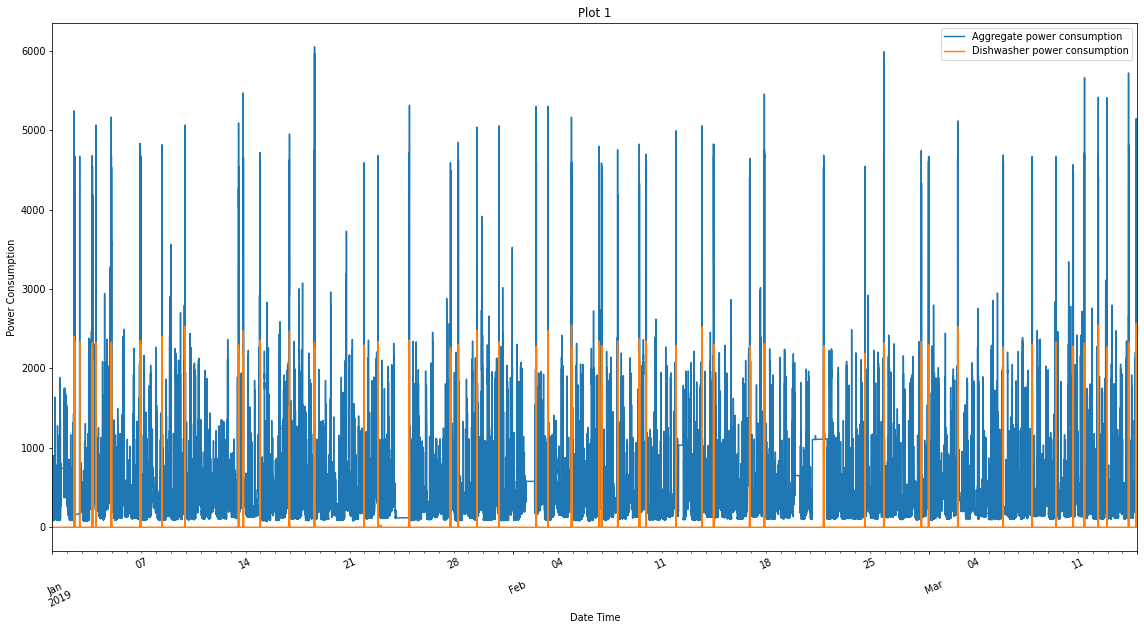

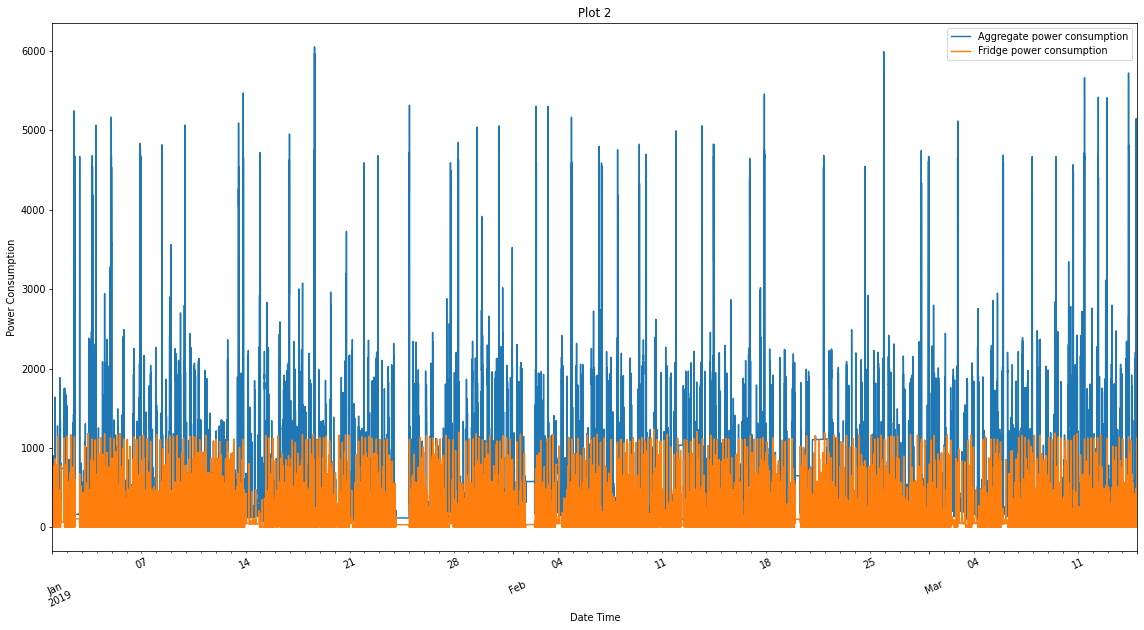

In [6]:
source_file_names = {
  '/content/drive/My Drive/main_train.csv' : 'Aggregate power consumption',
  '/content/drive/My Drive/dishwasher_train.csv' : 'Dishwasher power consumption',
  '/content/drive/My Drive/fridge_train.csv' : 'Fridge power consumption'                     
}

data = import_data(source_file_names)

plot_data(data, "Plot 1", ['Aggregate power consumption', 'Dishwasher power consumption'], "Date Time", "Power Consumption")
plot_data(data, "Plot 2", ['Aggregate power consumption', 'Fridge power consumption'], "Date Time", "Power Consumption")

## Dishwasher 

Current iteration:     0
Training set:          [0:2937600] -- [2019-01-01 00:00:00+01:00 to 2019-02-03 23:59:59+01:00]
Validation set:        [2937600:4406400] -- [2019-02-04 00:00:00+01:00 to 2019-02-20 23:59:59+01:00]
Ignored observations:  0

Current iteration:     1
Training set:          [950400:3888000] -- [2019-01-12 00:00:00+01:00 to 2019-02-14 23:59:59+01:00]
Validation set:        [3888000:5356800] -- [2019-02-15 00:00:00+01:00 to 2019-03-03 23:59:59+01:00]
Ignored observations:  950400

Current iteration:     2
Training set:          [1900800:4838400] -- [2019-01-23 00:00:00+01:00 to 2019-02-25 23:59:59+01:00]
Validation set:        [4838400:6307200] -- [2019-02-26 00:00:00+01:00 to 2019-03-14 23:59:59+01:00]
Ignored observations:  1900800

The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_6"
_________________

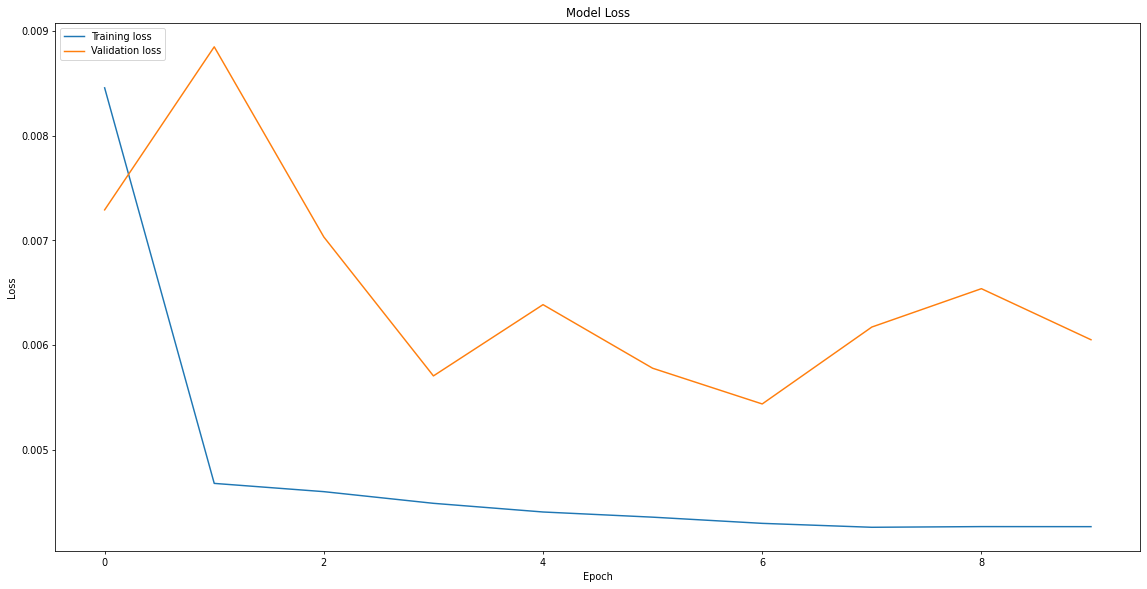

The number of filters                        : 8
The size of each kernel                      : 4
The number of neurons of Dense layer         : 32
The number of neurons in the recurrent layer : 32
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1, 8)              40        
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
______________________________________________________

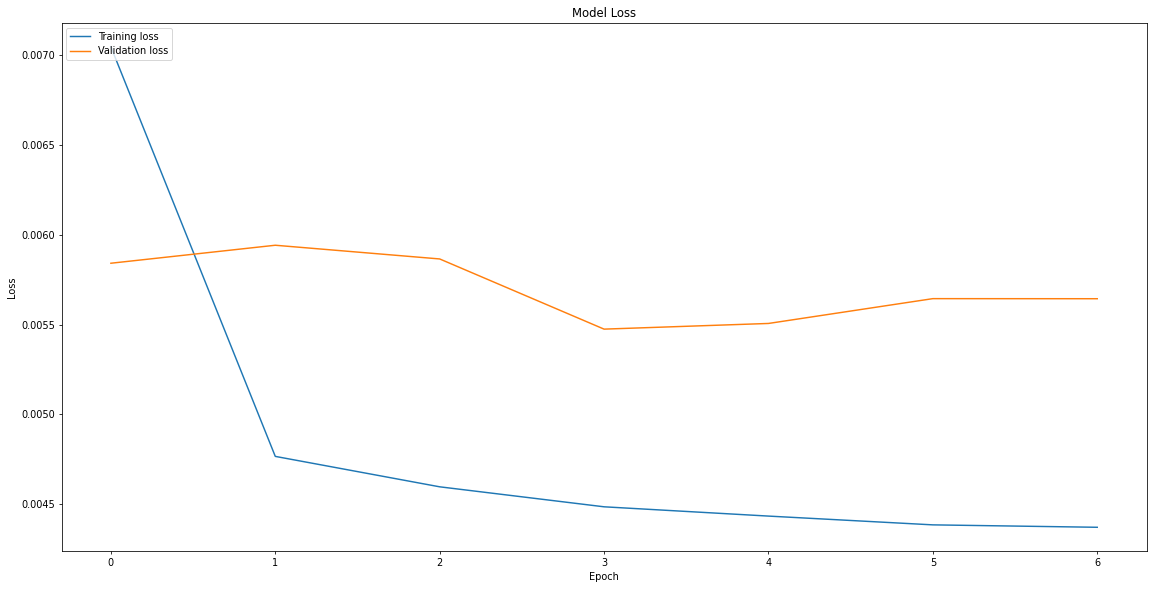

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 64
The number of neurons in the recurrent layer : 64
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_____________________________________________________

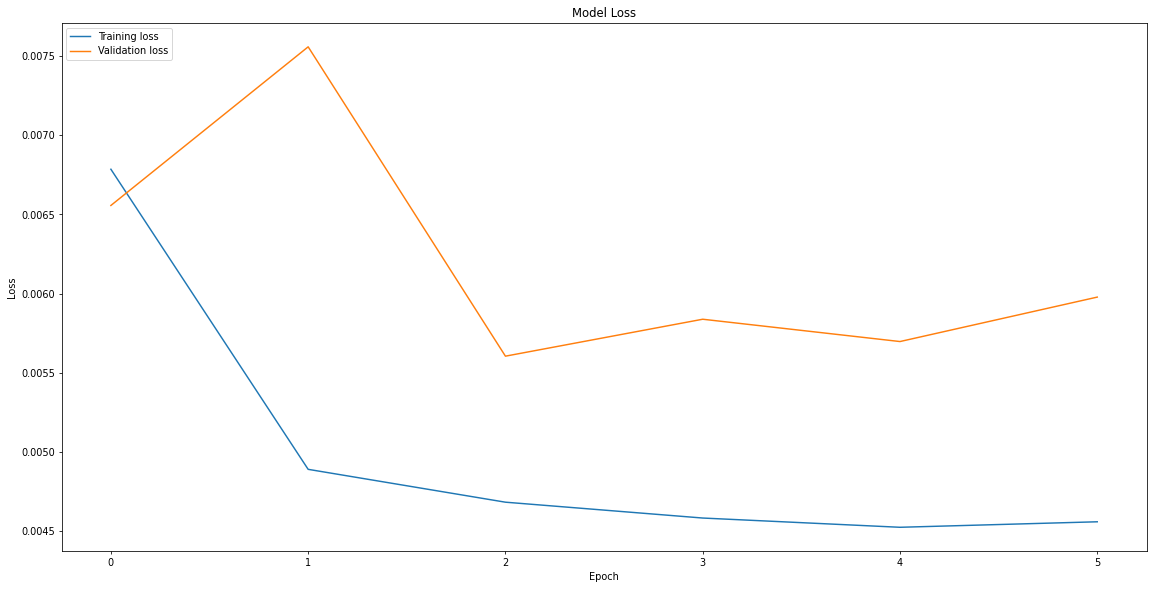

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 64
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
___________________________________________________

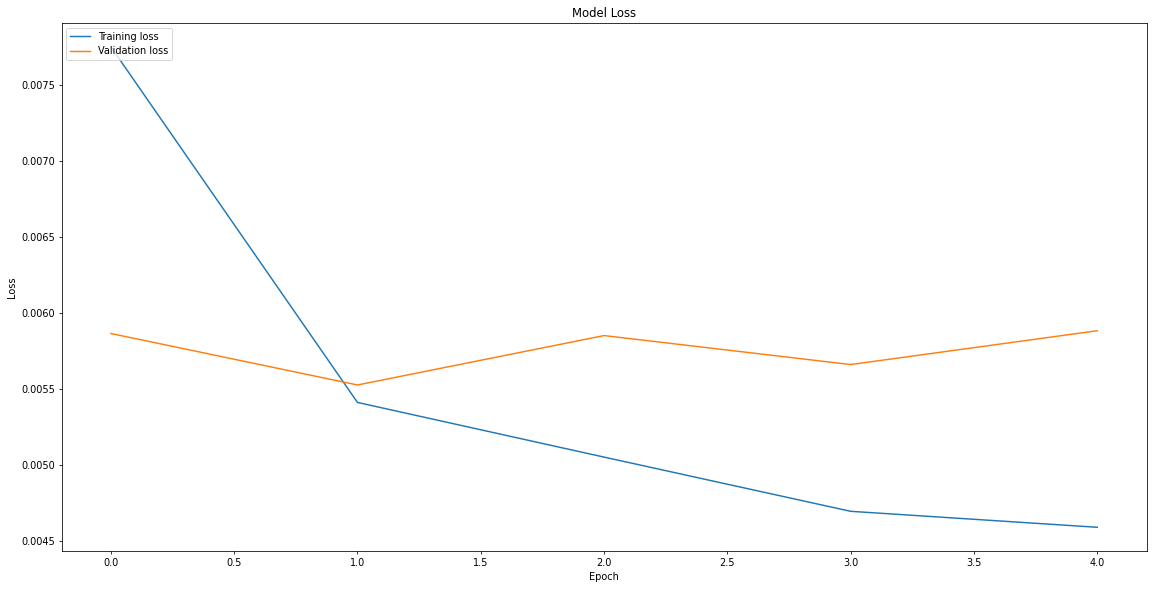

The number of filters                        : 32
The size of each kernel                      : 16
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 128
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 32)             544       
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_41 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
________________________________________________

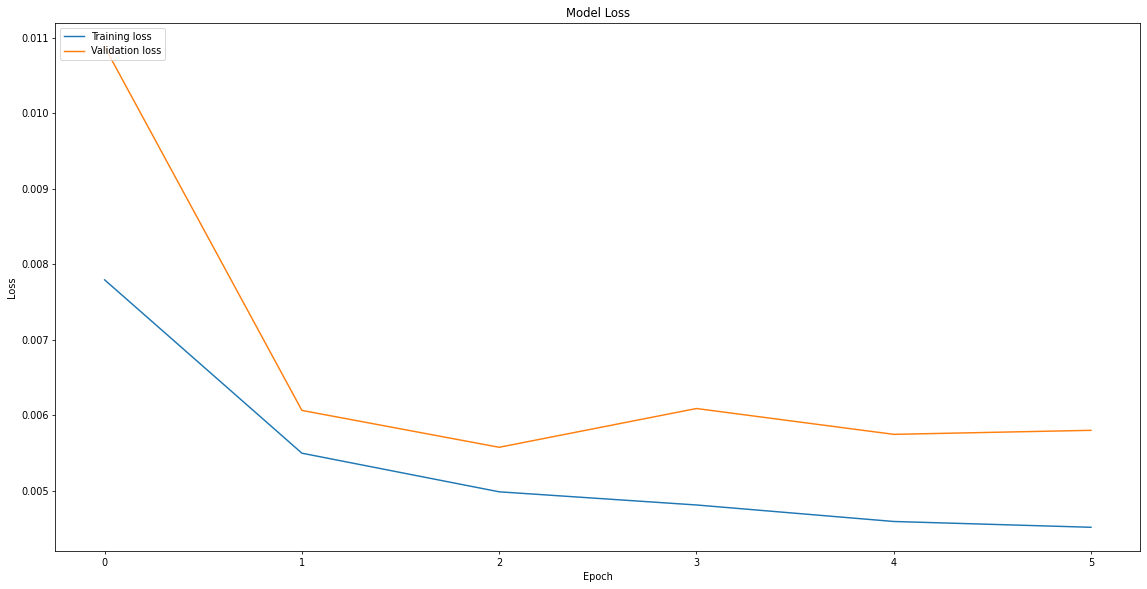

Best hyperparameters are:                [4, 2, 16, 16]
Number of epochs for final training are: 7
The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1, 4)              12        
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_44 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_46 (Dense)    

In [17]:
dishwasher_neural_network = NilmNeuralNetwork('dishwasher_neural_network', batch_size=256, number_of_features=1)
dishwasher_validation_technique = SlidingWindowWalkForward(data, 'Aggregate power consumption', 'Dishwasher power consumption', debug=False)

# Move sliding window to include target test set...
dishwasher_validation_technique.move_sliding_window(debug=False)
dishwasher_validation_technique.move_sliding_window(debug=False)

start(dishwasher_validation_technique, 
      dishwasher_neural_network, 
      'Dishwasher', 
      perform_training=True, 
      perform_test_set_evaluation=False)

dishwasher_neural_network.save_to_disk()

## Fridge

Current iteration:     0
Training set:          [0:2937600] -- [2019-01-01 00:00:00+01:00 to 2019-02-03 23:59:59+01:00]
Validation set:        [2937600:4406400] -- [2019-02-04 00:00:00+01:00 to 2019-02-20 23:59:59+01:00]
Ignored observations:  0

Current iteration:     1
Training set:          [950400:3888000] -- [2019-01-12 00:00:00+01:00 to 2019-02-14 23:59:59+01:00]
Validation set:        [3888000:5356800] -- [2019-02-15 00:00:00+01:00 to 2019-03-03 23:59:59+01:00]
Ignored observations:  950400

Current iteration:     2
Training set:          [1900800:4838400] -- [2019-01-23 00:00:00+01:00 to 2019-02-25 23:59:59+01:00]
Validation set:        [4838400:6307200] -- [2019-02-26 00:00:00+01:00 to 2019-03-14 23:59:59+01:00]
Ignored observations:  1900800

The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_12"
________________

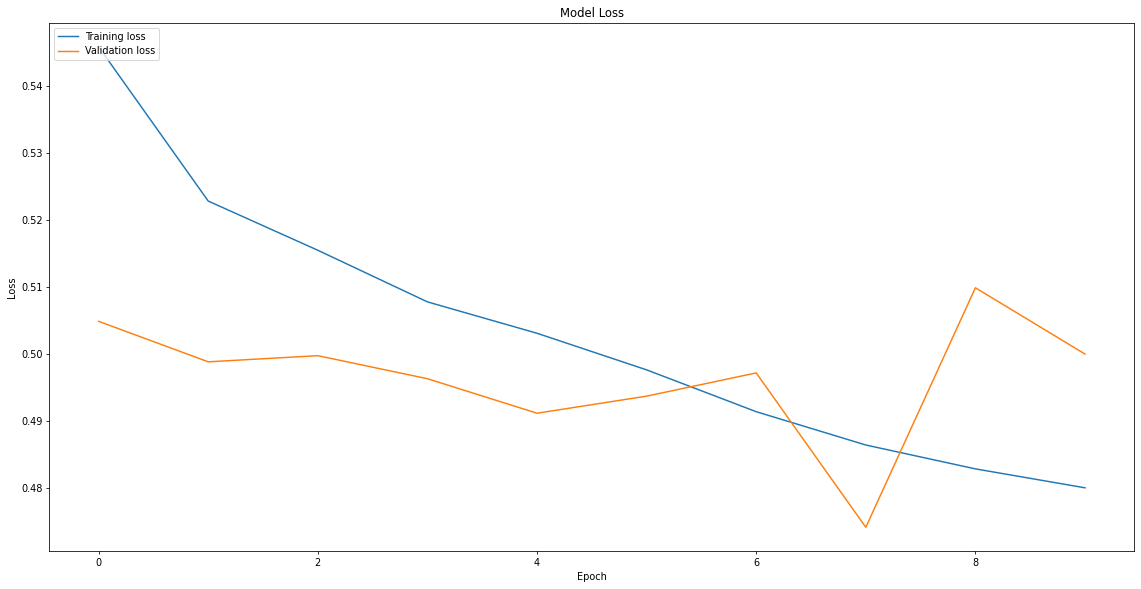

The number of filters                        : 8
The size of each kernel                      : 4
The number of neurons of Dense layer         : 32
The number of neurons in the recurrent layer : 32
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 4, 8)              40        
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_52 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_53 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 136       
_____________________________________________________

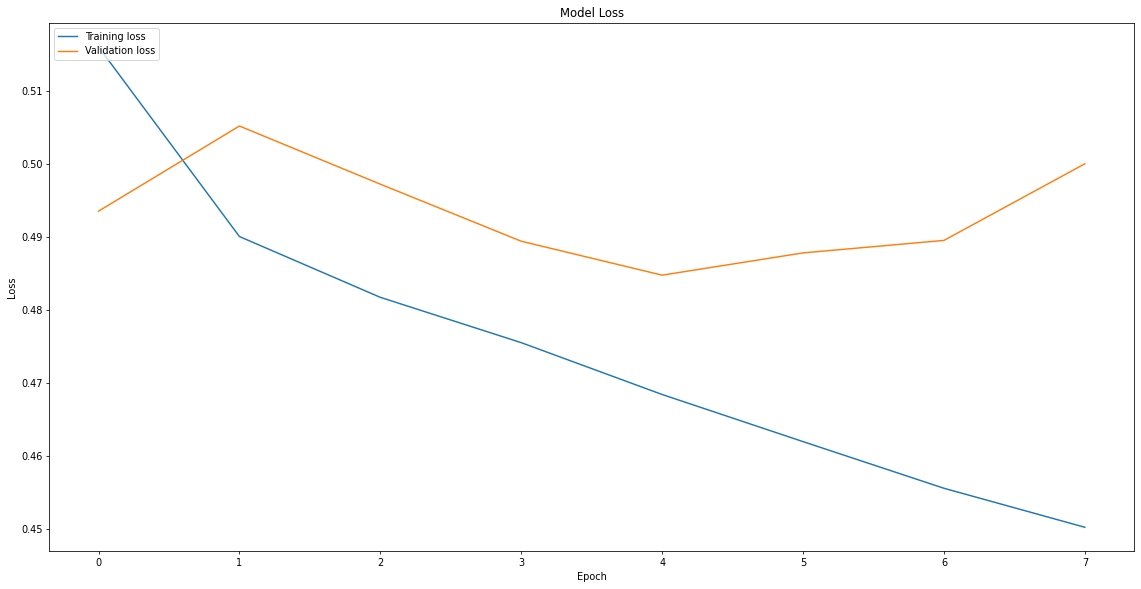

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 64
The number of neurons in the recurrent layer : 64
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 4, 16)             144       
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_58 (Dense)             (None, 16)                528       
____________________________________________________

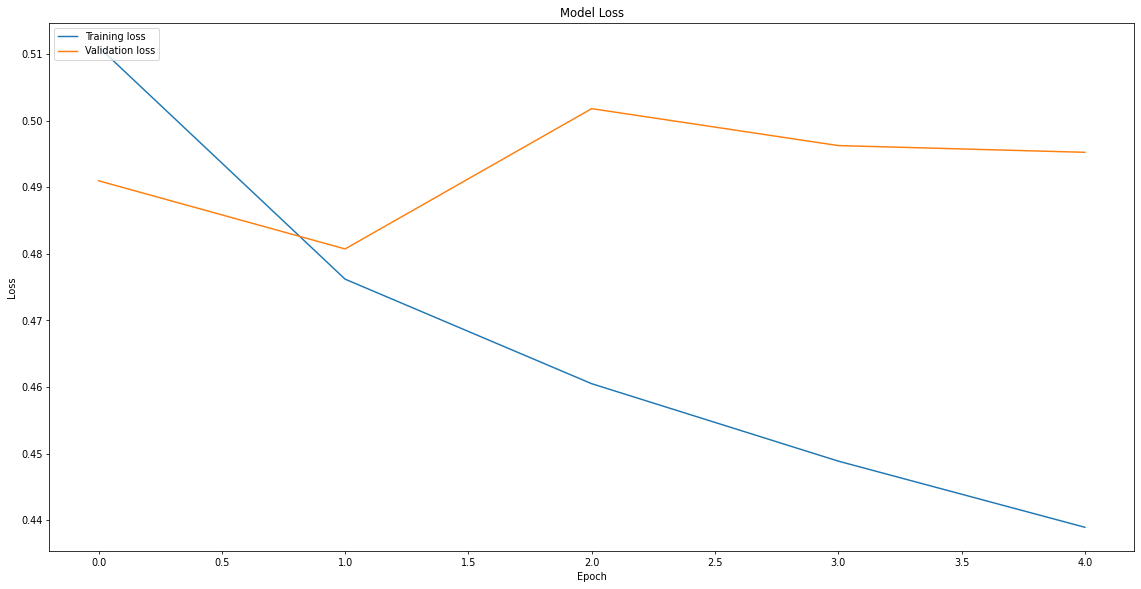

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 64
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 4, 16)             144       
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_61 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
__________________________________________________

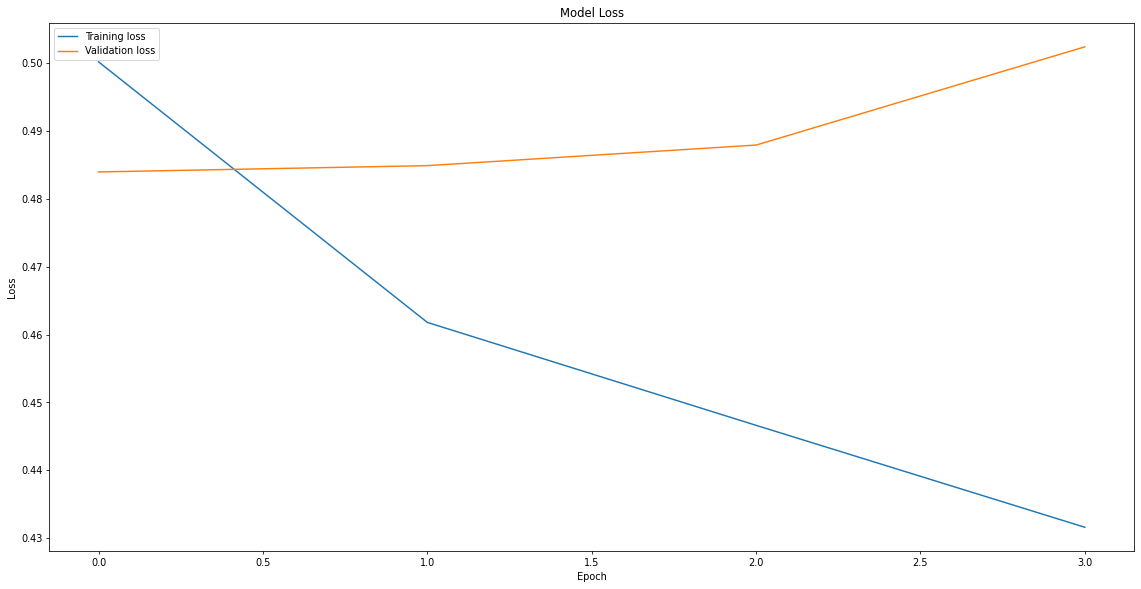

The number of filters                        : 32
The size of each kernel                      : 16
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 128
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 4, 32)             544       
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_65 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
________________________________________________

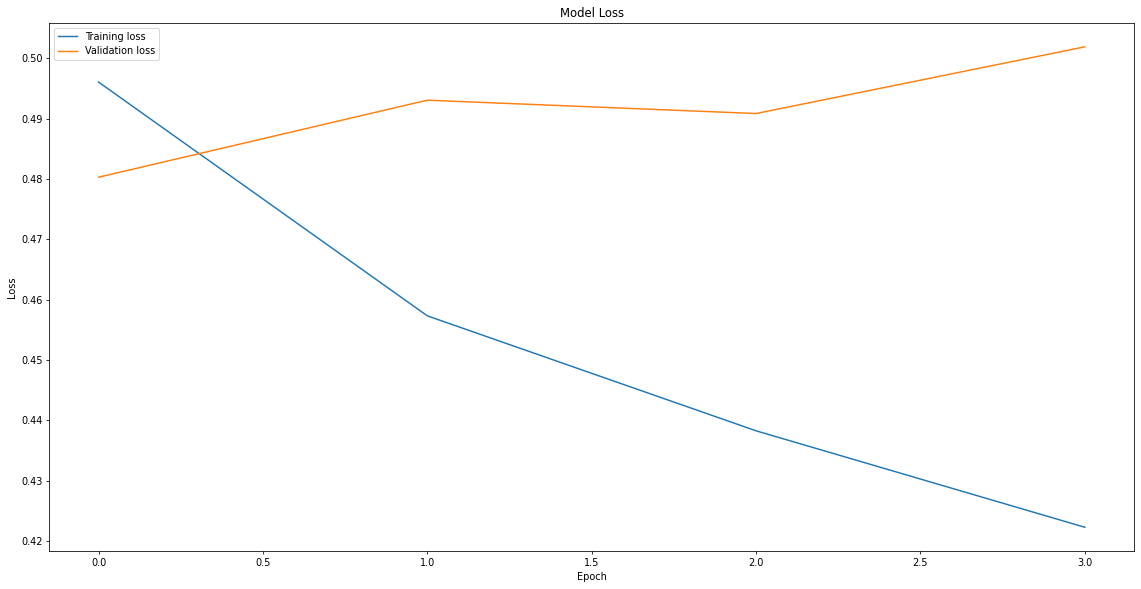

Best hyperparameters are:                [4, 2, 16, 16]
Number of epochs for final training are: 8
The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 4, 4)              12        
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_68 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_70 (Dense)    

In [19]:
fridge_neural_network = NilmNeuralNetwork('fridge_neural_network', batch_size=128, number_of_features=4)
fridge_validation_technique = SlidingWindowWalkForward(data, ['Aggregate power consumption', 'Min', 'Max', 'Mean'], 'Fridge power consumption',debug=False)

# Move sliding window to include target test set...
fridge_validation_technique.move_sliding_window(debug=False)
fridge_validation_technique.move_sliding_window(debug=False)

start(fridge_validation_technique, 
      fridge_neural_network, 
      'Fridge', 
      perform_training=True, 
      perform_test_set_evaluation=False)

fridge_neural_network.save_to_disk()

# Script for debug...

Current iteration:     0
Training set:          [0:2937600] -- [2019-01-01 00:00:00+01:00 to 2019-02-03 23:59:59+01:00]
Validation set:        [2937600:4406400] -- [2019-02-04 00:00:00+01:00 to 2019-02-20 23:59:59+01:00]
Test set:              [4406400:5875200] -- [2019-02-21 00:00:00+01:00 to 2019-03-09 23:59:59+01:00]
Ignored observations:  0

Test set size:                   1468800 (17.0 days!)
Validation set size:             1468800 (17.0 days!)
Training set size:               2937600 (34.0 days!)
Data size used during iteration: 5875200 (68.0 days!)
Sliding window step set size:    950400 (11.0 days!)
Number of iterations:            2
The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

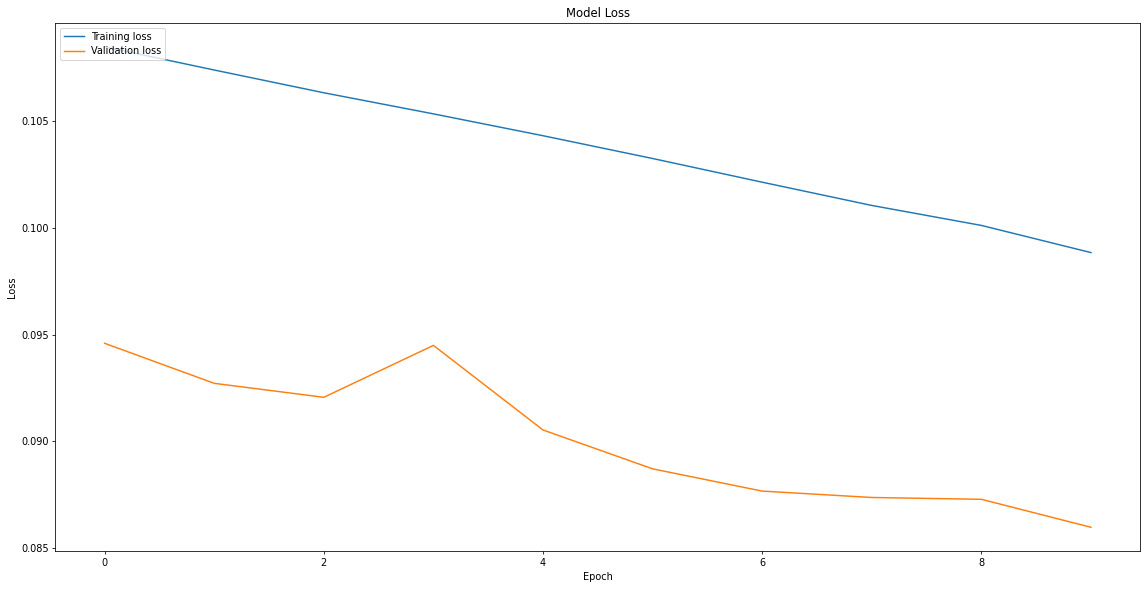

The number of filters                        : 8
The size of each kernel                      : 4
The number of neurons of Dense layer         : 32
The number of neurons in the recurrent layer : 32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 8)              40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
______________________________________________________

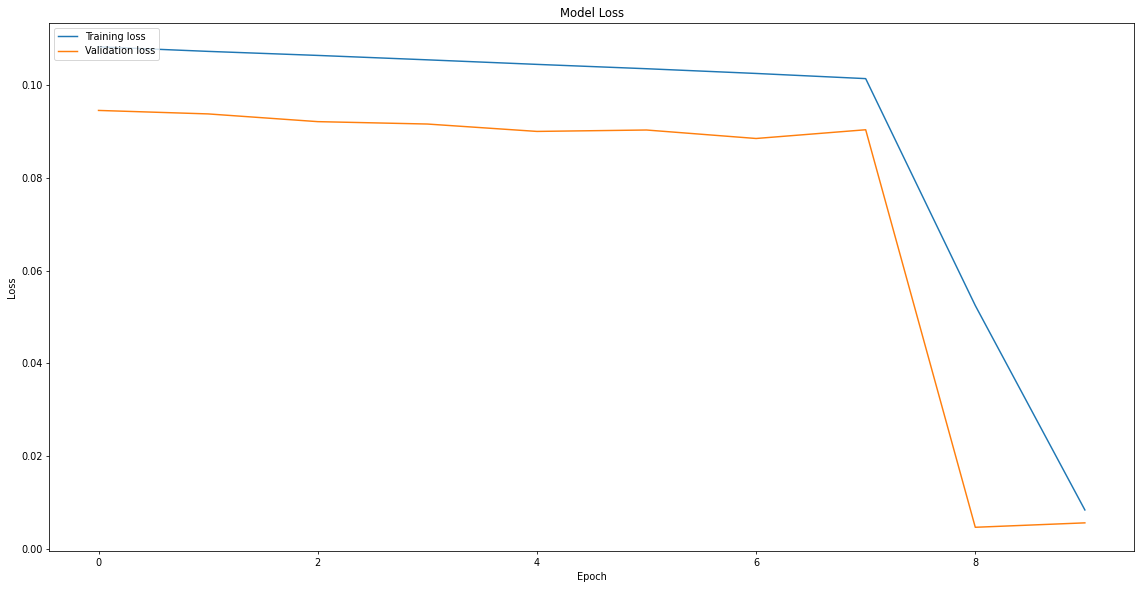

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 64
The number of neurons in the recurrent layer : 64
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_____________________________________________________

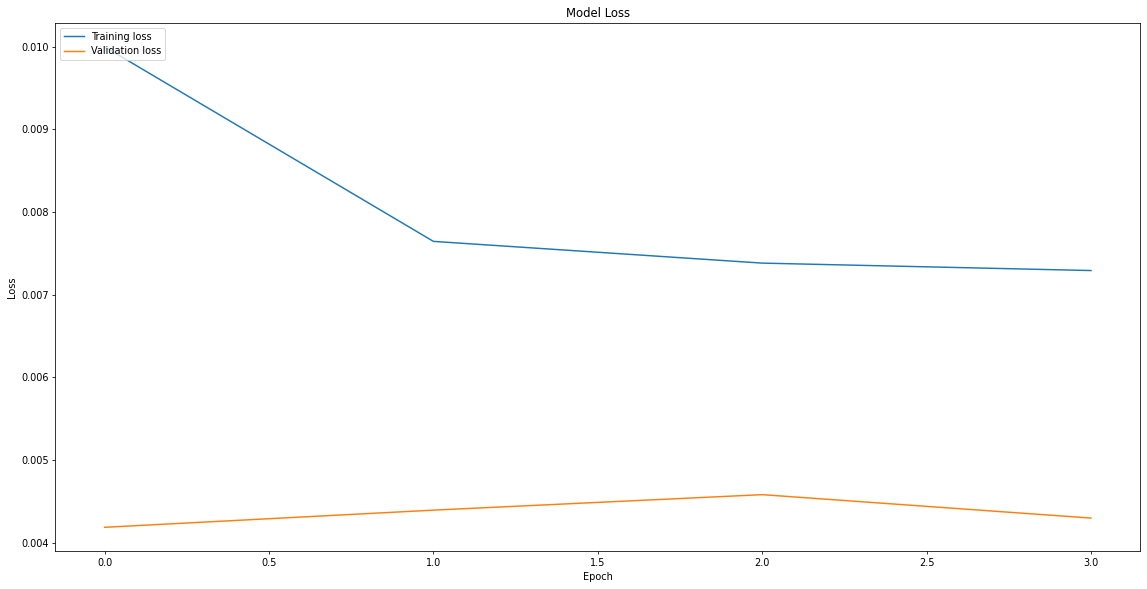

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 64
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
___________________________________________________

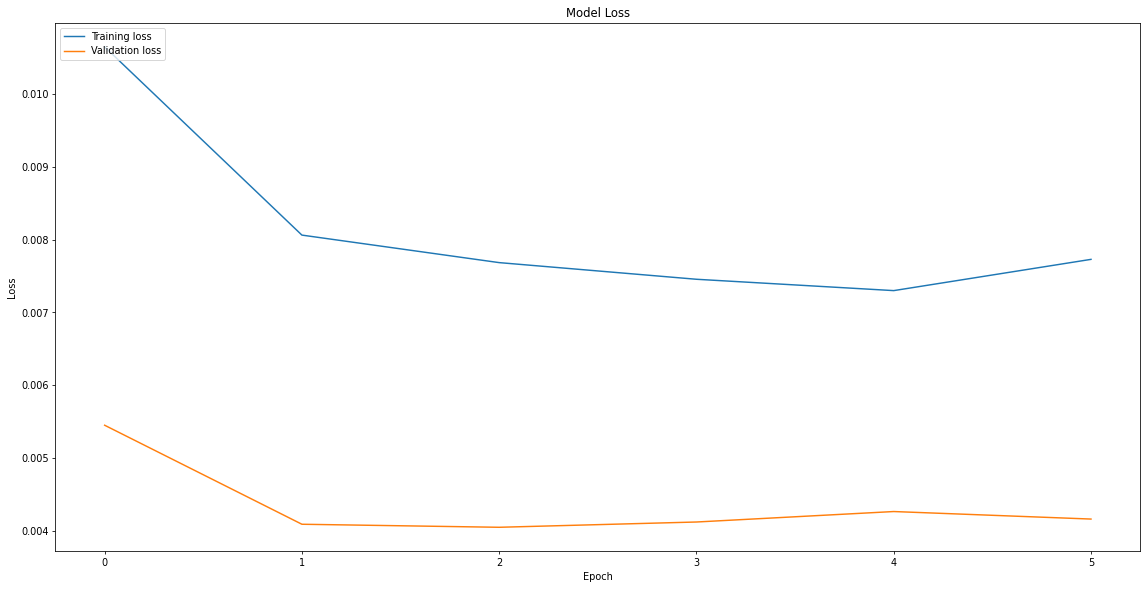

The number of filters                        : 32
The size of each kernel                      : 16
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 128
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 32)             544       
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________

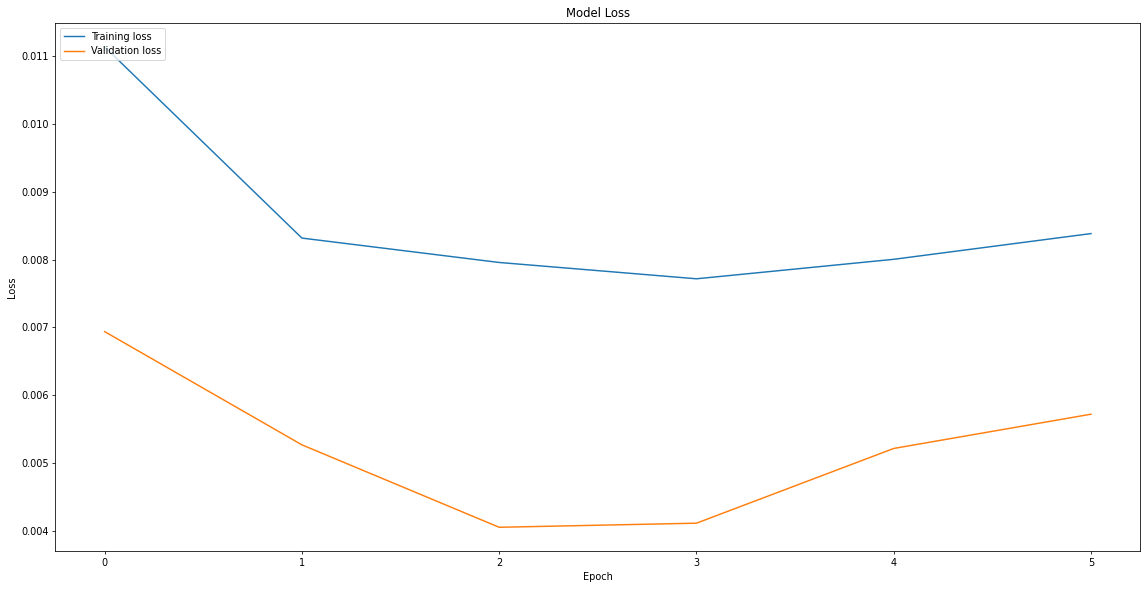

Best hyperparameters are:                [16, 8, 1024, 64]
Number of epochs for final training are: 3
The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 64
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_22 (Dense

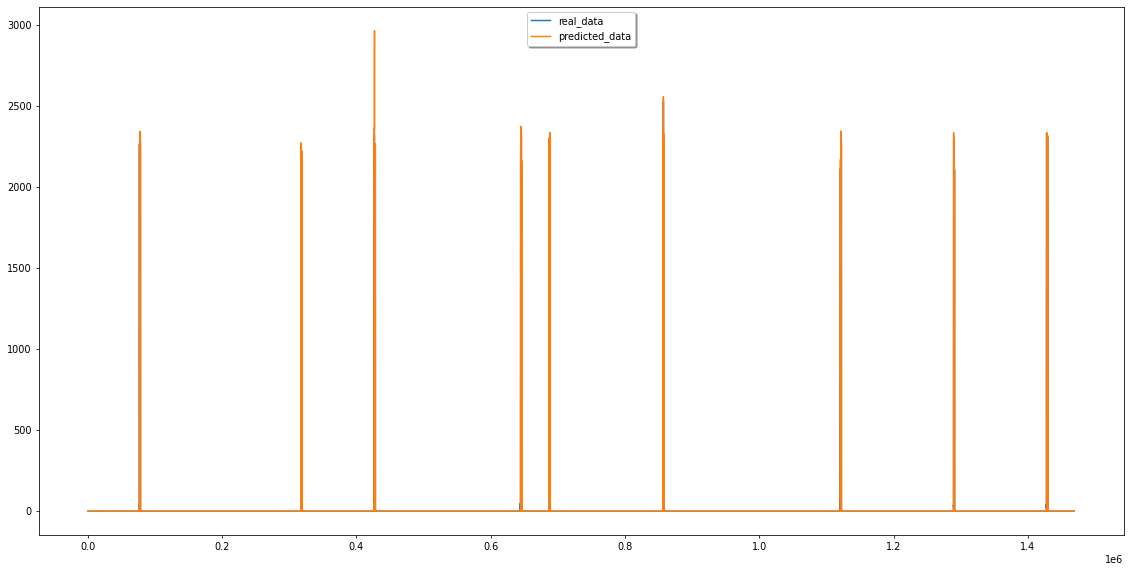

In [ ]:
dishwasher_neural_network = NilmNeuralNetwork('dishwasher_neural_network', batch_size=256, number_of_features=1)
dishwasher_validation_technique = SlidingWindowWalkForward(data, 'Aggregate power consumption', 'Dishwasher power consumption')

start(dishwasher_validation_technique, 
      dishwasher_neural_network, 
      'Dishwasher', 
      perform_training=True, 
      perform_test_set_evaluation=True)

Current iteration:     0
Training set:          [0:2937600] -- [2019-01-01 00:00:00+01:00 to 2019-02-03 23:59:59+01:00]
Validation set:        [2937600:4406400] -- [2019-02-04 00:00:00+01:00 to 2019-02-20 23:59:59+01:00]
Test set:              [4406400:5875200] -- [2019-02-21 00:00:00+01:00 to 2019-03-09 23:59:59+01:00]
Ignored observations:  0

Test set size:                   1468800 (17.0 days!)
Validation set size:             1468800 (17.0 days!)
Training set size:               2937600 (34.0 days!)
Data size used during iteration: 5875200 (68.0 days!)
Sliding window step set size:    950400 (11.0 days!)
Number of iterations:            2
The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #

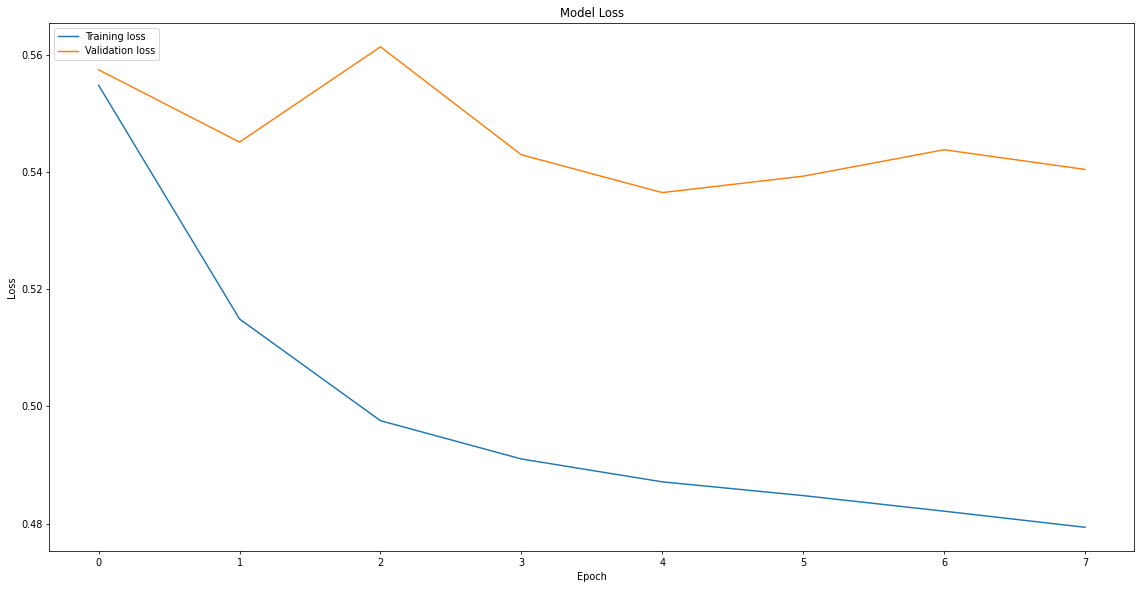

The number of filters                        : 8
The size of each kernel                      : 4
The number of neurons of Dense layer         : 32
The number of neurons in the recurrent layer : 32
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 4, 8)              40        
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
______________________________________________________

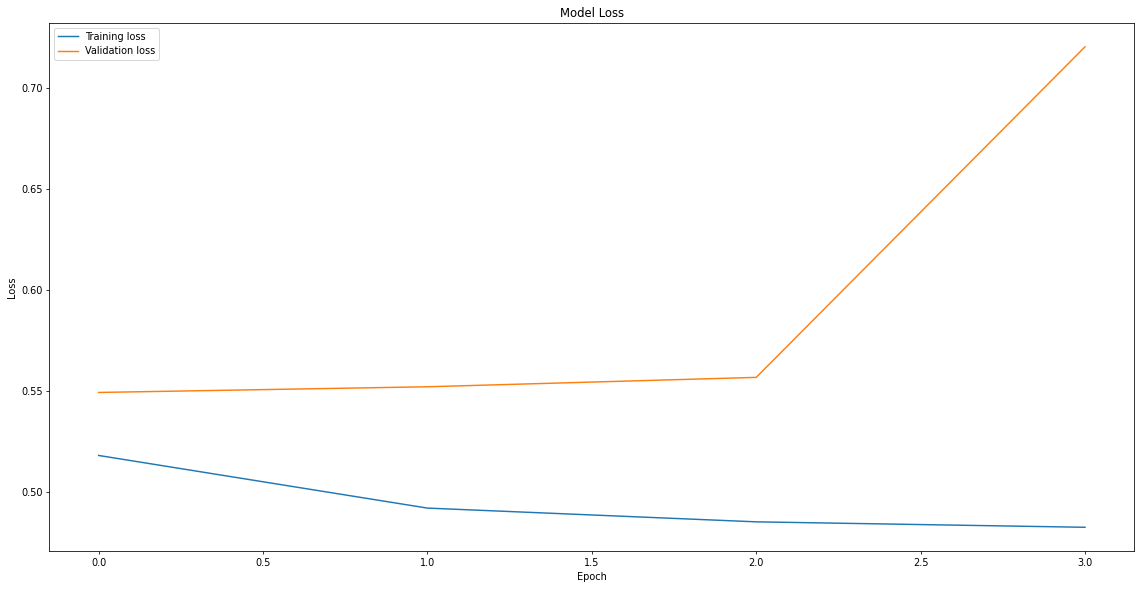

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 64
The number of neurons in the recurrent layer : 64
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 4, 16)             144       
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_____________________________________________________

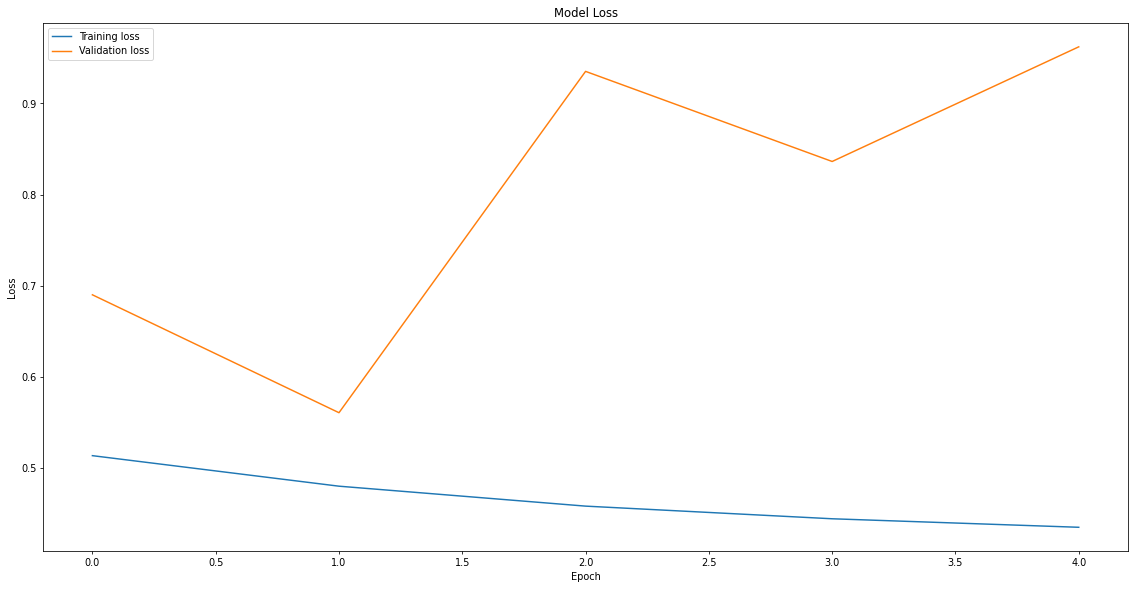

The number of filters                        : 16
The size of each kernel                      : 8
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 64
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 4, 16)             144       
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
___________________________________________________

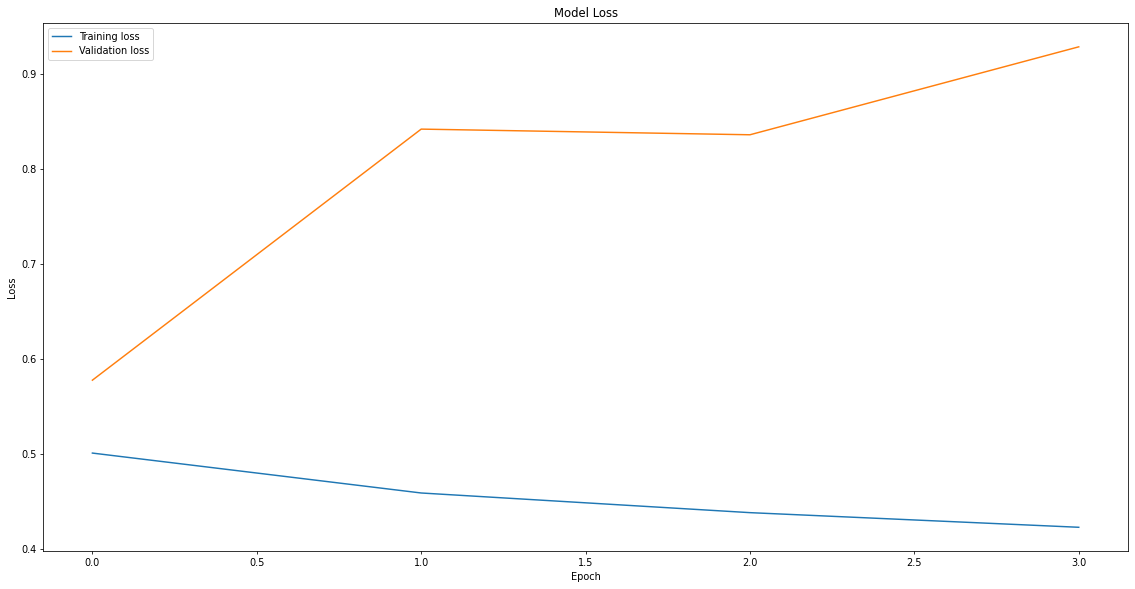

The number of filters                        : 32
The size of each kernel                      : 16
The number of neurons of Dense layer         : 1024
The number of neurons in the recurrent layer : 128
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 4, 32)             544       
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_41 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
________________________________________________

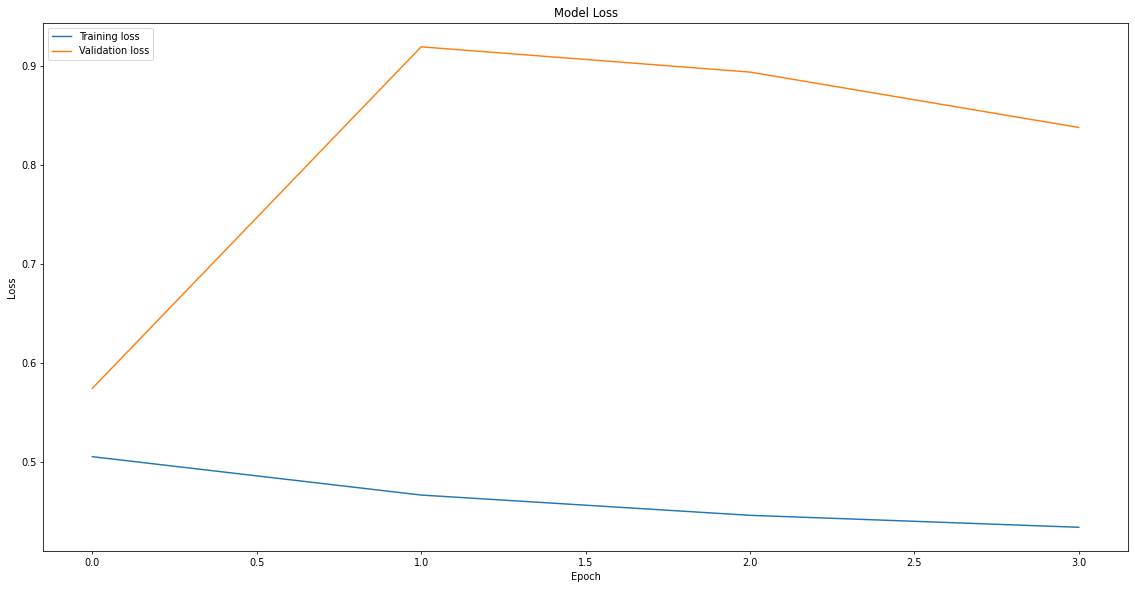

Best hyperparameters are:                [4, 2, 16, 16]
Number of epochs for final training are: 5
The number of filters                        : 4
The size of each kernel                      : 2
The number of neurons of Dense layer         : 16
The number of neurons in the recurrent layer : 16
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 4, 4)              12        
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_44 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_46 (Dense)    

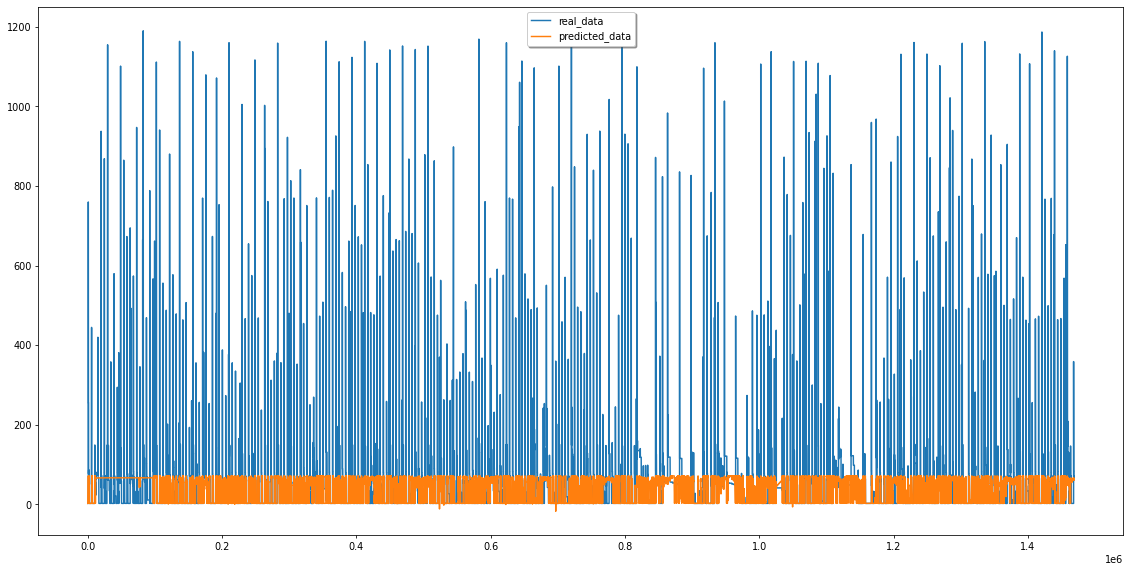

In [ ]:
fridge_neural_network = NilmNeuralNetwork('fridge_neural_network', batch_size=128, number_of_features=4)
fridge_validation_technique = SlidingWindowWalkForward(data, ['Aggregate power consumption', 'Min', 'Max', 'Mean'], 'Fridge power consumption')

start(fridge_validation_technique, 
      fridge_neural_network, 
      'Fridge', 
      perform_training=True, 
      perform_test_set_evaluation=True)

# Script for final testing...

Both training data and final test data are required! 
If needed, please modify filenames.

In [ ]:
# Following dictionary includes (source_filename, column_name) pairs regarding TRAINING DATA...
source_file_names_train = {
  '/content/drive/My Drive/main_train.csv' : 'Aggregate power consumption',
  '/content/drive/My Drive/dishwasher_train.csv' : 'Dishwasher power consumption',
  '/content/drive/My Drive/fridge_train.csv' : 'Fridge power consumption'                     
}

# Following dictionary includes (source_filename, column_name) pairs regarding FINAL TEST DATA... 
source_file_names_test = {
  '/content/drive/My Drive/main_test.csv' : 'Aggregate power consumption',
  '/content/drive/My Drive/dishwasher_test.csv' : 'Dishwasher power consumption',
  '/content/drive/My Drive/fridge_test.csv' : 'Fridge power consumption'                     
}

print("Please wait...")
data1 = import_data(source_file_names_train)
data2 = import_data(source_file_names_test)
data = pandas.concat([data1, data2])

Run following to test the neural network for dishwasher...

In [ ]:
dishwasher_neural_network = NilmNeuralNetwork('dishwasher_neural_network', batch_size=256, number_of_features=1)
dishwasher_validation_technique = SlidingWindowWalkForward(data, 'Aggregate power consumption', 'Dishwasher power consumption', debug=False)

# Move sliding window to include target test set...
dishwasher_validation_technique.move_sliding_window(debug=False)
dishwasher_validation_technique.move_sliding_window()

dishwasher_neural_network.load_from_disk()

start(dishwasher_validation_technique, 
      dishwasher_neural_network, 
      'Dishwasher', 
      perform_training=False, 
      perform_test_set_evaluation=True)


Run following to test the neural network for fridge...

In [ ]:
fridge_neural_network = NilmNeuralNetwork('fridge_neural_network', batch_size=128, number_of_features=4)
fridge_validation_technique = SlidingWindowWalkForward(data, ['Aggregate power consumption', 'Min', 'Max', 'Mean'], 'Fridge power consumption', debug=False)

# Move sliding window to include target test set...
fridge_validation_technique.move_sliding_window(debug=False)
fridge_validation_technique.move_sliding_window()

fridge_neural_network.load_from_disk()

start(fridge_validation_technique, 
      fridge_neural_network, 
      'Fridge', 
      perform_training=False, 
      perform_test_set_evaluation=True)